This notebook will demonstrate how to use the **constrained training algorithms** implemented in this toolkit with **PyTorch**-like API.

The algorithms implemented in the **humancompatible.train.torch** subpackage share a similar idea. Before the training, you initialize an algorithm like you would a PyTorch one. Then, during the training process, you:

1. Evaluate a constraint and compute its gradient
2. Call the `dual_step` function to update dual parameters and save the constraint gradient for the primal update
3. Call the `step` function to update the primal parameters (generally, model weights)

Let's try the Stochastic Smooth Linearized Augmented Lagrangian (SSLALM) algorithm on a constrained learning task.

Let's train a simple classification model, putting a constraint on the norm of each layer's parameters.

In the canonical form, the algorithm expects equality constraints that are equal to 0; however, we can easily transform arbitrary inequality constraints to that form.

In [1]:
# load and prepare data

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import numpy as np
from folktables import ACSDataSource, ACSIncome, generate_categories

# load folktables data
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["VA"], download=True)
definition_df = data_source.get_definitions(download=True)
categories = generate_categories(features=ACSIncome.features, definition_df=definition_df)
df_feat, df_labels, _ = ACSIncome.df_to_pandas(acs_data,categories=categories, dummies=True)

sens_cols = ['SEX_Female', 'SEX_Male']
features = df_feat.drop(columns=sens_cols).to_numpy(dtype="float")
groups = df_feat[sens_cols].to_numpy(dtype="float")
labels = df_labels.to_numpy(dtype="float")
# split
X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(
    features, labels, groups, test_size=0.2, random_state=42)
# scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# make into a pytorch dataset, remove the sensitive attribute
features_train = torch.tensor(X_train, dtype=torch.float32)
labels_train = torch.tensor(y_train,dtype=torch.float32)
sens_train = torch.tensor(groups_train)
dataset_train = torch.utils.data.TensorDataset(features_train, labels_train)

In [2]:
import folktables

ACSIncomeSexRace = folktables.BasicProblem(
    features=ACSIncome.features,
    target="PINCP",
    target_transform=lambda x: x > 50000,
    group=["SEX", "RAC1P"],
    preprocess=folktables.adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["VA"], download=True)
definition_df = data_source.get_definitions(download=True)
categories = generate_categories(features=ACSIncomeSexRace.features, definition_df=definition_df)
df_feat, df_labels, _ = ACSIncomeSexRace.df_to_pandas(acs_data,categories=categories, dummies=True)

In [ ]:
from humancompatible.train.optim import SSLALM
import torch
from torch.nn import Sequential

dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=16, shuffle=True)

hsize1 = 64
hsize2 = 32
model = Sequential(
    torch.nn.Linear(features_train.shape[1], hsize1),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize1, hsize2),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize2, 1)
)

m = len(list(model.parameters()))

optimizer = SSLALM(
    params=model.parameters(),
    m=m,
    lr=0.01,
    dual_lr=0.1
)
# bounds for the constraints: norm of each param group should be <= 1
constraint_bounds = [1.]*m

epochs = 10
criterion = torch.nn.BCEWithLogitsLoss()

In [4]:
for epoch in range(epochs):
    loss_log = []
    c_log = []
    slack_log = []
    duals_log = []
    for batch_input, batch_label in dataloader:
        # calculate constraints and constraint grads
        c_log.append([])
        for i, param in enumerate(model.parameters()):
            norm = torch.linalg.norm(param, ord=2)
            # convert constraint to equality
            norm_viol = torch.max(
                norm 
                - constraint_bounds[i],
                torch.zeros(1)
            )
            norm_viol.backward()
            # for the Lagrangian family of algorithms, dual_step requires the index of constraint and the value as arguments
            # to update the corresponding dual multiplier
            # in a stochastic-constrained setting, this estimate needs (in theory) to be independent from the one used to update dual parameters
            # in practice, it makes little difference
            optimizer.dual_step(i, c_val=norm_viol.squeeze())
            optimizer.zero_grad()
            c_log[-1].append(norm.detach().numpy())
        
        # calculate loss and grad
        batch_output = model(batch_input)
        loss = criterion(batch_output, batch_label)
        loss.backward()
        loss_log.append(loss.detach().numpy())
        duals_log.append(optimizer._dual_vars.detach())
        optimizer.step()
        optimizer.zero_grad()
    
    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.mean(c_log, axis=0)}, "
        f"dual: {np.mean(duals_log, axis=0)}"
    )

Epoch: 0, loss: 0.5691204071044922, constraints: [0.89047617 0.26562378 0.962312   0.37444922 0.84837437 0.054888  ], dual: [0.15567237 0.         0.15227382 0.         0.18878356 0.        ]
Epoch: 1, loss: 0.4511478543281555, constraints: [0.9998718  0.6844714  0.99995524 0.5348424  0.9998333  0.0216115 ], dual: [0.21187708 0.         0.23442917 0.         0.26534405 0.        ]
Epoch: 2, loss: 0.4315645098686218, constraints: [0.99953127 0.9721475  0.99952567 0.58417565 0.9993649  0.0277731 ], dual: [0.24975747 0.02706908 0.2918276  0.         0.31720373 0.        ]
Epoch: 3, loss: 0.4228110611438751, constraints: [0.99927455 0.99989223 0.9991891  0.61135066 0.99910396 0.03787826], dual: [0.27880716 0.03535462 0.33642703 0.         0.3614033  0.        ]
Epoch: 4, loss: 0.41685885190963745, constraints: [0.99913347 0.99983275 0.9989497  0.62882423 0.9988548  0.03394982], dual: [0.30230263 0.04068753 0.3746812  0.         0.39726186 0.        ]
Epoch: 5, loss: 0.41210687160491943, co

The model is now trained subject to the constraints we set.

---
---

It is also possible to train a network subject to **stochastic constraints**. One of the main use-cases for that is **fairness**. Let's train a network on the `folktables` dataset without constraints first, so we can identify some biases:

Define a model:

In [5]:
from torch.nn import Sequential
hsize1 = 64
hsize2 = 32
model_uncon = Sequential(
    torch.nn.Linear(features_train.shape[1], hsize1),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize1, hsize2),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize2, 1)
)

And start training:

In [6]:
from torch.optim import Adam

loader = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=True)
loss = torch.nn.BCEWithLogitsLoss()
optimizer = Adam(model_uncon.parameters())
epochs = 50

for epoch in range(epochs):
    losses = []
    for batch_feat, batch_label in dataloader:
        optimizer.zero_grad()

        logit = model_uncon(batch_feat)
        loss = torch.nn.functional.binary_cross_entropy_with_logits(logit, batch_label)
        loss.backward()

        optimizer.step()
        losses.append(loss.item())
    print(f"Epoch: {epoch}, loss: {np.mean(losses)}")

Epoch: 0, loss: 0.43397876271974795
Epoch: 1, loss: 0.39611734298624396
Epoch: 2, loss: 0.3830184707033934
Epoch: 3, loss: 0.3712298125771086
Epoch: 4, loss: 0.35654665978441413
Epoch: 5, loss: 0.34105762846742077
Epoch: 6, loss: 0.32607585578943815
Epoch: 7, loss: 0.30976841409095085
Epoch: 8, loss: 0.2934261847011409
Epoch: 9, loss: 0.27781738827660346
Epoch: 10, loss: 0.2640928285748438
Epoch: 11, loss: 0.24870842579910388
Epoch: 12, loss: 0.2371279752968231
Epoch: 13, loss: 0.22368608362084186
Epoch: 14, loss: 0.2124615433988338
Epoch: 15, loss: 0.2039922530223346
Epoch: 16, loss: 0.19187396837630838
Epoch: 17, loss: 0.1863508616470379
Epoch: 18, loss: 0.1749377901582338
Epoch: 19, loss: 0.17023141634582284
Epoch: 20, loss: 0.16181556919464143
Epoch: 21, loss: 0.15323571830894517
Epoch: 22, loss: 0.15121482238330858
Epoch: 23, loss: 0.14385798919526901
Epoch: 24, loss: 0.1409150229017327
Epoch: 25, loss: 0.13319290822777477
Epoch: 26, loss: 0.12964797244229487
Epoch: 27, loss: 0.12

In [7]:
from fairret.statistic import PositiveRate, TruePositiveRate
from fairret.loss import NormLoss

preds = torch.nn.functional.sigmoid(model_uncon(features_train))
pr = PositiveRate()
pr(preds, sens_train)

tensor([0.3569, 0.5062], dtype=torch.float64, grad_fn=<IndexPutBackward0>)

---
---

Now let us train the same model with one of the **constrained** training algorithms:

Here, to make sure each batch contains representatives of each protected group, we can use the BalancedBatchSampler from the `utils` subpackage - a custom PyTorch `Sampler` which yields an equal number of samples from each subgroup in each batch.

In [8]:
from fairret.statistic import PositiveRate
from fairret.loss import NormLoss
from humancompatible.train.fairness.utils import BalancedBatchSampler

dataset = torch.utils.data.TensorDataset(features_train, sens_train, labels_train)

sampler = BalancedBatchSampler(
    subgroup_onehot=sens_train,
    batch_size=128,
    drop_last=True
)
dataloader = torch.utils.data.DataLoader(dataset, batch_sampler=sampler)

criterion = torch.nn.BCEWithLogitsLoss()

statistic = PositiveRate()
fair_criterion = NormLoss(statistic=statistic)
fair_crit_bound = 0.2

In [ ]:
from torch.nn import Sequential
hsize1 = 64
hsize2 = 32
model_con = Sequential(
    torch.nn.Linear(features_train.shape[1], hsize1),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize1, hsize2),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize2, 1)
)

from humancompatible.train.optim import SSLALM_Adam

optimizer = SSLALM_Adam(
    params=model_con.parameters(),
    m=1,
    lr=0.01,
    dual_lr=0.05,
    dual_bound=5,
    rho=1,
    mu=2,
)

# add slack variables
slack_vars = torch.zeros(1, requires_grad=True)
optimizer.add_param_group(param_group={"params": slack_vars, "name": "slack"})

epochs = 50

As the constraint, we use `NormLoss` from `fairret`, which penalizes the model based on the ratio between the value of a statistic for each group and the overall value: $\sum_{s\in S}{|1-\frac{f(\theta, X_s, y_s)}{f(\theta, X, y)}|}$.

In [10]:
ep_c_log = []
for epoch in range(epochs):
    loss_log = []
    c_log = []
    duals_log = []
    for batch_input, batch_sens, batch_label in dataloader:
        # calculate constraints and constraint grads
        out = model_con(batch_input)
        fair_loss = fair_criterion(out, batch_sens)
        # fair_constraint = torch.max(fair_loss + slack_vars[0] - fair_crit_bound, torch.zeros(1))
        fair_constraint = fair_loss + slack_vars[0] - fair_crit_bound
        fair_constraint.backward(retain_graph=True)
        
        optimizer.dual_step(0, c_val=fair_constraint)
        optimizer.zero_grad()

        c_log.append([fair_loss.detach().item()])
        duals_log.append(optimizer._dual_vars.detach())
        # calculate loss and grad
        loss = criterion(out, batch_label) + 0 * slack_vars[0]
        loss.backward()
        loss_log.append(loss.detach().numpy())
        optimizer.step()
        optimizer.zero_grad()

        # slack variables must be non-negative. this is the "projection" step from the SSL-ALM paper
        with torch.no_grad():
            for s in slack_vars:
                if s < 0:
                    s.zero_()
        
    optimizer.dual_lr *= 0.95
    ep_c_log.extend(c_log)
    
    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.mean(c_log, axis=0)}, "
        f"dual: {np.mean(duals_log, axis=0)}"
    )

Epoch: 0, loss: 0.4723413586616516, constraints: [0.15362729], dual: [0.00954109]
Epoch: 1, loss: 0.40194377303123474, constraints: [0.19762402], dual: [-0.00233644]
Epoch: 2, loss: 0.3871115446090698, constraints: [0.20302055], dual: [0.09634538]
Epoch: 3, loss: 0.3789052665233612, constraints: [0.19651585], dual: [0.05487603]
Epoch: 4, loss: 0.37101271748542786, constraints: [0.19697223], dual: [0.02092461]
Epoch: 5, loss: 0.36328527331352234, constraints: [0.20564231], dual: [0.08178654]
Epoch: 6, loss: 0.35936546325683594, constraints: [0.195664], dual: [0.03836441]
Epoch: 7, loss: 0.3519388735294342, constraints: [0.20053481], dual: [0.0436604]
Epoch: 8, loss: 0.3438510596752167, constraints: [0.20442865], dual: [0.08456553]
Epoch: 9, loss: 0.3367249667644501, constraints: [0.19617766], dual: [0.05108259]
Epoch: 10, loss: 0.3309421241283417, constraints: [0.2006629], dual: [0.05659958]
Epoch: 11, loss: 0.3223046362400055, constraints: [0.20371469], dual: [0.0859691]
Epoch: 12, los

In [11]:
from fairret.statistic import PositiveRate

preds = torch.nn.functional.sigmoid(model_con(features_train))
pr = PositiveRate()
pr(preds, sens_train)

tensor([0.3970, 0.4726], dtype=torch.float64, grad_fn=<IndexPutBackward0>)

In [12]:
fair_criterion(model_con(features_train), sens_train)

tensor(0.1734, dtype=torch.float64, grad_fn=<SumBackward0>)

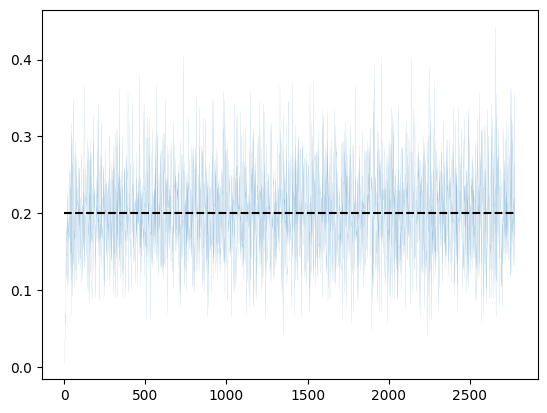

In [13]:
from matplotlib import pyplot as plt

window_len = 5
c_mavg = np.array([np.mean(ep_c_log[i:i+window_len]) for i in range(0, len(ep_c_log), window_len)])
plt.plot(np.array(c_mavg).flatten(), lw=0.05)
plt.hlines(y=fair_crit_bound, xmin=0, xmax=len(c_mavg), colors='black', ls='--')

---

Now let's see how the **Switching Subgradient** algorithm deals with this task.

In [14]:
from fairret.statistic import PositiveRate
from fairret.loss import NormLoss
from humancompatible.train.fairness.utils import BalancedBatchSampler

dataset = torch.utils.data.TensorDataset(features_train, sens_train, labels_train)

sampler = BalancedBatchSampler(
    subgroup_onehot=sens_train,
    batch_size=128,
    drop_last=True
)
dataloader = torch.utils.data.DataLoader(dataset, batch_sampler=sampler)

criterion = torch.nn.BCEWithLogitsLoss()

statistic = PositiveRate()
fair_criterion = NormLoss(statistic=statistic)
fair_crit_bound = 0.2

In [ ]:
from humancompatible.train.optim import SSG

from torch.nn import Sequential
hsize1 = 64
hsize2 = 32
model_con = Sequential(
    torch.nn.Linear(features_train.shape[1], hsize1),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize1, hsize2),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize2, 1)
)

optimizer = SSG(
    params=model_con.parameters(),
    m=1,
    lr=0.05,
    dual_lr=0.05
)

epochs = 150

In [16]:
ep_c_log = []
for epoch in range(epochs):
    loss_log = []
    c_log = []
    duals_log = []
    for batch_input, batch_sens, batch_label in dataloader:
        # calculate constraints and constraint grads
        out = model_con(batch_input)
        fair_loss = fair_criterion(out, batch_sens)
        fair_constraint = torch.max(fair_loss - fair_crit_bound, torch.zeros(1))
        fair_constraint.backward(retain_graph=True)
        
        optimizer.dual_step(0)
        optimizer.zero_grad()

        c_log.append([fair_loss.detach().item()])
        # calculate loss and grad
        # batch_output = model_con(batch_input)
        loss = criterion(out, batch_label)
        loss.backward()
        loss_log.append(loss.detach().numpy())
        optimizer.step(fair_constraint)
        optimizer.zero_grad()
        
    ep_c_log.append(c_log)
    
    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.mean(c_log, axis=0)}, "
    )

Epoch: 0, loss: 0.5917466878890991, constraints: [0.04786117], 
Epoch: 1, loss: 0.4411052465438843, constraints: [0.11162637], 
Epoch: 2, loss: 0.42034682631492615, constraints: [0.118806], 
Epoch: 3, loss: 0.4125017821788788, constraints: [0.11083734], 
Epoch: 4, loss: 0.40751808881759644, constraints: [0.11344068], 
Epoch: 5, loss: 0.40191248059272766, constraints: [0.11465657], 
Epoch: 6, loss: 0.3978845477104187, constraints: [0.11297438], 
Epoch: 7, loss: 0.3947388827800751, constraints: [0.119367], 
Epoch: 8, loss: 0.3940359950065613, constraints: [0.11786867], 
Epoch: 9, loss: 0.39513063430786133, constraints: [0.12467096], 
Epoch: 10, loss: 0.3876039683818817, constraints: [0.11998452], 
Epoch: 11, loss: 0.3815326690673828, constraints: [0.12117832], 
Epoch: 12, loss: 0.3790724277496338, constraints: [0.11952363], 
Epoch: 13, loss: 0.3804245889186859, constraints: [0.11458447], 
Epoch: 14, loss: 0.3790796101093292, constraints: [0.11459803], 
Epoch: 15, loss: 0.3752559423446655

In [17]:
from fairret.statistic import PositiveRate

preds = torch.nn.functional.sigmoid(model_con(features_train))
pr = PositiveRate()
pr(preds, sens_train)

tensor([0.4588, 0.4788], dtype=torch.float64, grad_fn=<IndexPutBackward0>)

In [18]:
fair_criterion(model_con(features_train), sens_train)

tensor(0.0427, dtype=torch.float64, grad_fn=<SumBackward0>)

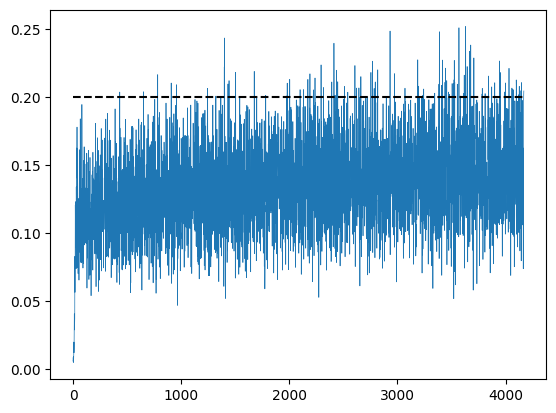

In [19]:
from matplotlib import pyplot as plt

ep_c_log = np.array(ep_c_log).flatten()
window_len = 10
c_mavg = np.array([np.mean(ep_c_log[i:i+window_len]) for i in range(0, len(ep_c_log), window_len)])
plt.plot(np.array(c_mavg).flatten(), lw=0.5)
plt.hlines(y=fair_crit_bound, xmin=0, xmax=len(c_mavg), colors='black', ls='--')